In [3]:
#  STEP 1: Install dependencies
! pip install rasterio tensorflow scikit-learn tqdm

#  STEP 2: Imports
import os
import numpy as np
import rasterio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip NDVI files from Google Drive
import shutil

zip_path = "/content/drive/MyDrive/ndvi_july_dec_2023.zip"
extract_to = "/content/ndvi_july_dec_2023"

# Copy zip to /content before unzipping
shutil.copy(zip_path, "/content/ndvi_july_dec_2023.zip")
!unzip -q /content/ndvi_july_dec_2023.zip -d /content/ndvi_july_dec_2023
!ls -R /content/ndvi_july_dec_2023

#  STEP 3: Load all NDVI GeoTIFFs into a 3D array
# folder = "/content/ndvi_tiffs"
folder = "/content/ndvi_july_dec_2023/ndvi_july_dec_2023"
# folder = "/kaggle/input/ndvi-jan-june-2022/ndvi_tiffs/"
files = sorted([f for f in os.listdir(folder) if f.endswith('.tif')])
print(files)

# print(files)
# exit()

ndvi_stack = []

print("Reading NDVI images...")

for f in files:
    with rasterio.open(os.path.join(folder, f)) as src:
        data = src.read(1).astype('float32')
        ndvi_stack.append(data)

print(type(ndvi_stack[0]))
ndvi_stack = np.array(ndvi_stack)  # Shape: [time, height, width]
time, height, width = ndvi_stack.shape

print(f"Loaded NDVI stack with shape: {ndvi_stack.shape}")

print("NDVI shape:", ndvi_stack.shape)
print("NDVI stats:", np.nanmin(ndvi_stack), np.nanmax(ndvi_stack))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_09_September_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_10_October_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_11_November_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_07_July_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_12_December_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/ndvi_july_dec_2023/ndvi_july_dec_2023/NDVI_08_August_2023_Krishna.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
/content/ndvi_july_dec_2023:
ndvi_july_dec_2023

/content/ndvi_july_dec_2023/ndvi_july_dec_2023:


In [4]:
ndvi_stack

for i, layer in enumerate(ndvi_stack):
    nans = np.isnan(layer).sum()
    print(f"Time step {i}: {nans} NaN values")

total_nans = np.isnan(ndvi_stack).sum()
print("Total NaN values in NDVI stack:", total_nans)

total_pixels = np.prod(ndvi_stack.shape)
nan_percentage = (total_nans / total_pixels) * 100
print(f"Percentage of NaN values: {nan_percentage:.2f}%")


Time step 0: 21024067 NaN values
Time step 1: 21024438 NaN values
Time step 2: 21024824 NaN values
Time step 3: 21033458 NaN values
Time step 4: 21025246 NaN values
Time step 5: 21026222 NaN values
Total NaN values in NDVI stack: 126158255
Percentage of NaN values: 68.17%


(6, 5308, 5811)
Pixels that are NaN in ALL timesteps: 21023606


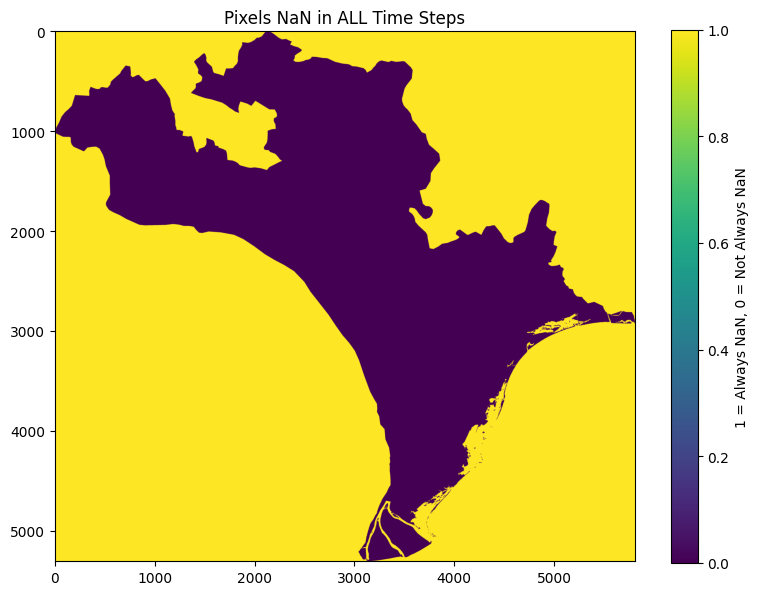

In [5]:
nan_masks = np.isnan(ndvi_stack)  # (time, height, width)
print(nan_masks.shape)

# --- Check where all time steps are NaN ---
consistent_nan_mask = np.all(nan_masks, axis=0)  # (height, width)
consistent_nan_count = np.sum(consistent_nan_mask)
print("Pixels that are NaN in ALL timesteps:", consistent_nan_count)

# --- Optional: visualize consistent NaN locations ---
plt.figure(figsize=(8, 6))
plt.imshow(consistent_nan_mask, cmap='viridis')
plt.title("Pixels NaN in ALL Time Steps")
plt.colorbar(label="1 = Always NaN, 0 = Not Always NaN")
plt.tight_layout()
plt.show()

In [6]:
ndvi_scaled = np.empty_like(ndvi_stack, dtype=np.float32)
mins = np.full((height, width), np.nan, dtype=np.float32)
maxs = np.full((height, width), np.nan, dtype=np.float32)

print("Normalizing pixels with NumPy...")
for i in tqdm(range(height)):
    for j in range(width):
        series = ndvi_stack[:, i, j]
        if np.isnan(series).any() or np.all(series == 0):
            ndvi_scaled[:, i, j] = np.nan
            continue
        min_val = np.nanmin(series)
        max_val = np.nanmax(series)
        if max_val - min_val == 0:
            ndvi_scaled[:, i, j] = np.nan
        else:
            ndvi_scaled[:, i, j] = (series - min_val) / (max_val - min_val)
            mins[i, j] = min_val
            maxs[i, j] = max_val

Normalizing pixels with NumPy...


100%|██████████| 5308/5308 [06:27<00:00, 13.69it/s]


In [7]:
import os
import numpy as np
import rasterio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt



normalized=True
seq_length = 5  # Use 5 months to predict the 6th
X_all = []
y_all = []
coords_all = []
# valid_mask = np.ones((height, width), dtype=bool)
# for t in range(time):
#     valid_mask = valid_mask & ~np.isnan(ndvi_scaled[t])
print("Preparing training data...")
for i in tqdm(range(height)):
    for j in range(width):
        # if not valid_mask[i, j]:
        #     continue
        if normalized:
            series=ndvi_scaled[:, i, j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use first 5 months to predict the 6th month
        X_all.append(series[:seq_length])
        y_all.append(series[seq_length])
        coords_all.append([i, j])

# Convert to numpy arrays and reshape for LSTM
X_all = np.array(X_all).reshape(-1, seq_length, 1)
y_all = np.array(y_all)
coords_all = np.array(coords_all)

print(f"Training data prepared: X shape: {X_all.shape}, y shape: {y_all.shape}")


Preparing training data...


100%|██████████| 5308/5308 [02:10<00:00, 40.59it/s]


Training data prepared: X shape: (9804597, 5, 1), y shape: (9804597,)


In [8]:

def create_lstm_model(seq_length):
    pixel_input = Input(shape=(seq_length, 1))  # NDVI time series input
    coord_input = Input(shape=(2,))  # Pixel coordinates (i, j)

    # LSTM layers
    # lstm_1 = LSTM(50, return_sequences=True)(pixel_input)
    lstm_1 = LSTM(32, return_sequences=True)(pixel_input)
    lstm_2 = LSTM(50)(lstm_1)

    # Concatenate LSTM output with coordinates for spatial awareness
    concat = Concatenate()([lstm_2, coord_input])

    # Output layer
    output = Dense(1)(concat)

    # Define the model
    model = tf.keras.Model(inputs=[pixel_input, coord_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

print("Training LSTM model...")
model = create_lstm_model(seq_length)
model.fit(
    [X_all,coords_all],
    y_all,
    validation_split = 0.2,
    epochs=5,
    batch_size=2048,
    verbose=1
)
model_path = "/content/drive/MyDrive/ndvi_lstm_model_jan_2024.keras"
model.save(model_path)

Training LSTM model...
Epoch 1/5
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 314s 81ms/step - loss: 11995.4873 - val_loss: 1.2489
Epoch 2/5
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 312s 81ms/step - loss: 0.1696 - val_loss: 0.1072
Epoch 3/5
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 312s 81ms/step - loss: 0.0808 - val_loss: 0.1180
Epoch 4/5
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 319s 81ms/step - loss: 0.0846 - val_loss: 0.0621
Epoch 5/5
3830/3830 ━━━━━━━━━━━━━━━━━━━━ 323s 81ms/step - loss: 0.0945 - val_loss: 0.0582


In [9]:
predicted = np.full((height, width), np.nan, dtype=np.float32)
print("prepring data for Predicting NDVI for the 7th month...")
X_test=[]
coords_test = []

for i in tqdm(range(height)):
    for j in range(width):
        if normalized:
            series=ndvi_scaled[:,i,j]
        else:
            series = ndvi_stack[:, i, j]
        if np.isnan(series).any():
            continue

        # Use all 6 months to predict the 7th month

        X_test.append(series[1:])
        coords_test.append([i,j])

        # # Inverse transform the prediction to original scale
        # if scalers[i, j] is not None:
        #     predicted[i, j] = scalers[i, j].inverse_transform(pred_scaled.reshape(-1, 1))[0][0]

X_test = np.array(X_test).reshape(-1, seq_length, 1)
coords_test = np.array(coords_test)

prepring data for Predicting NDVI for the 7th month...


100%|██████████| 5308/5308 [02:04<00:00, 42.57it/s]


In [10]:
print("predicting for 7th month")
y_pred = model.predict([X_test, coords_test], batch_size=2048, verbose=1)

print("converting back to 2d grid")
print(y_pred.shape)
for idx, (i, j) in tqdm(enumerate(coords_test)):
    if normalized:
        min_val = mins[i, j]
        max_val = maxs[i, j]
        assert not np.isnan(min_val) and not np.isnan(max_val)
        predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
    else:
        predicted[i, j] = y_pred[idx]

predicting for 7th month
4788/4788 ━━━━━━━━━━━━━━━━━━━━ 152s 32ms/step
converting back to 2d grid
(9804597, 1)


0it [00:00, ?it/s]<ipython-input-10-2dbf15bb067a>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted[i, j] = y_pred[idx] * (maxs[i,j]-mins[i,j]) + mins[i,j]
9804597it [01:50, 88923.09it/s] 


Saving prediction to GeoTIFF...
Prediction saved as: predicted_ndvi_jan_2024.tif


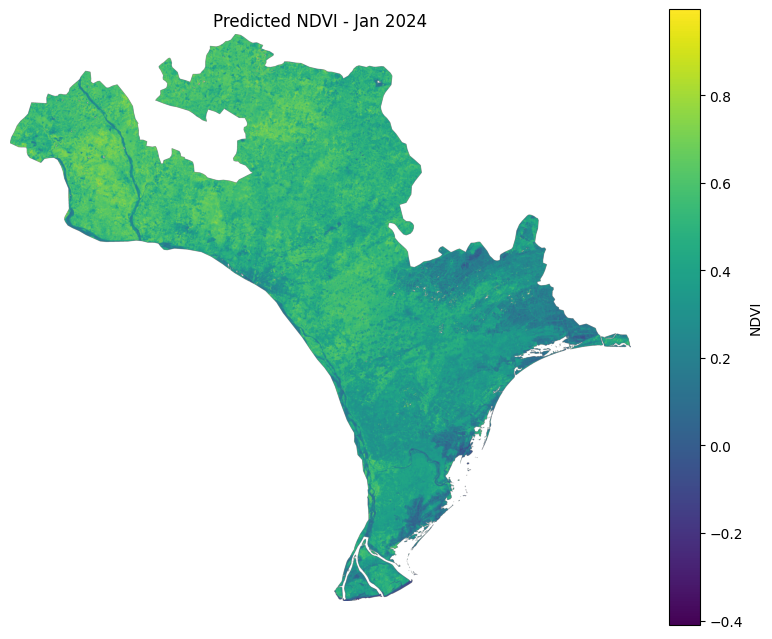

In [11]:
# STEP 6: Save prediction as GeoTIFF
print("Saving prediction to GeoTIFF...")#
# Use last image as template
with rasterio.open(os.path.join(folder, files[-1])) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open("/content/drive/MyDrive/predicted_ndvi_jan_2024.tif", "w", **profile) as dst:
        dst.write(predicted.astype(np.float32), 1)#
print("Prediction saved as: predicted_ndvi_jan_2024.tif")#
# STEP 7: Preview the prediction
plt.figure(figsize=(10, 8))
plt.imshow(predicted, cmap='viridis')
plt.colorbar(label='NDVI')
plt.title("Predicted NDVI - Jan 2024")
plt.axis('off')
plt.savefig("/content/drive/MyDrive/predicted_ndvi_jan_2024.png", dpi=300)
plt.show()

NaN count: 21040191
NaN percentage: 68.21%


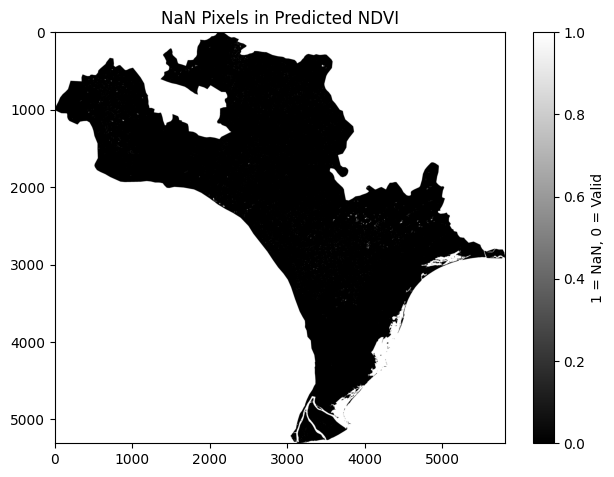

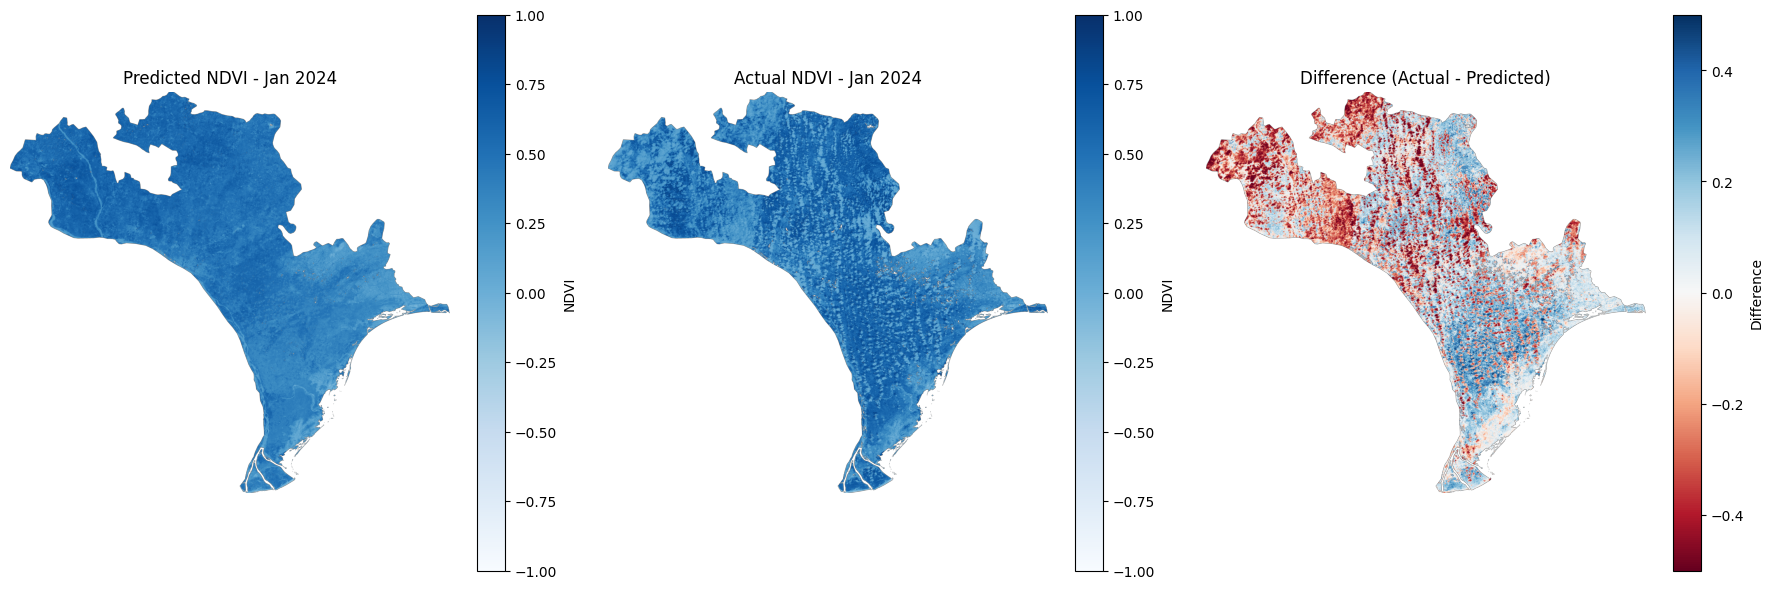

Root Mean Square Error (RMSE): 0.2408
Mean Absolute Error (MAE): 0.1960
R² Score: -0.0840


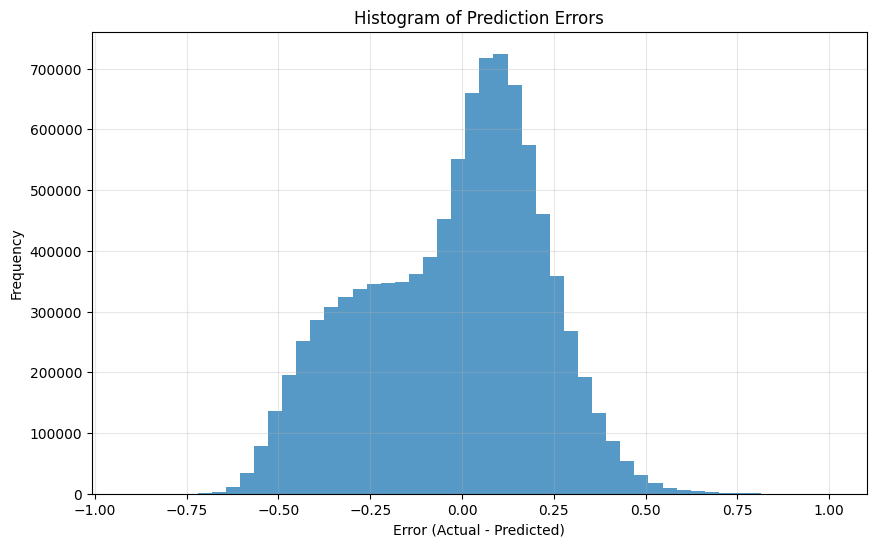

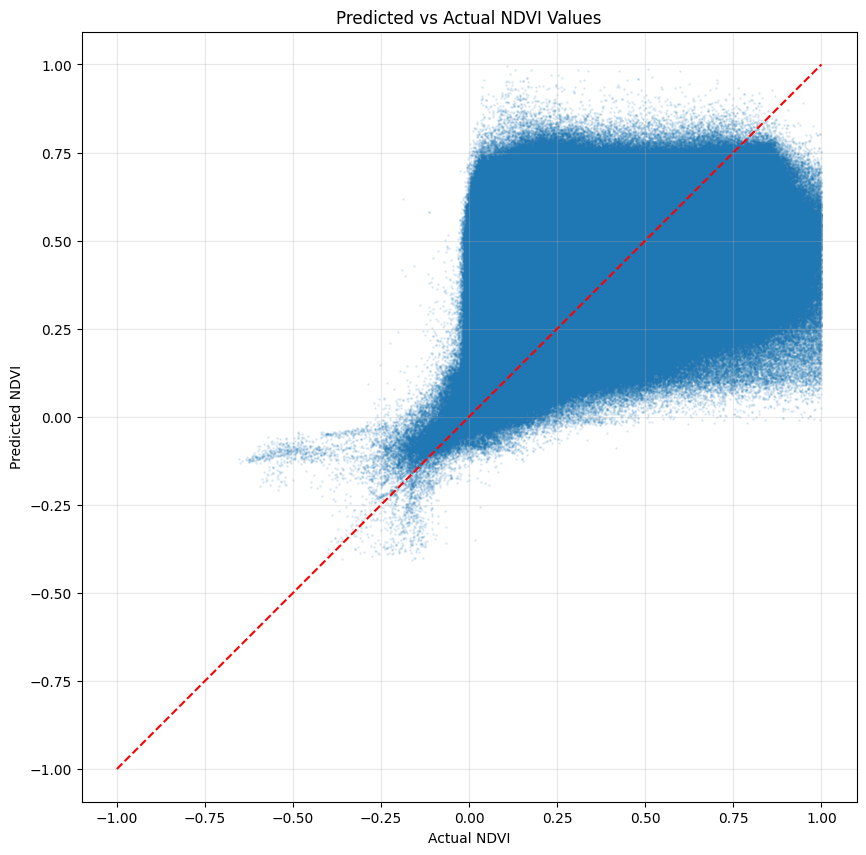

In [13]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Load both rasters
predicted_path = r"/content/drive/MyDrive/predicted_ndvi_jan_2024.tif"
actual_path = r"/content/drive/MyDrive/NDVI_LSTM/NDVI_01_January_2024_Krishna.tif"  # Adjust to actual path

with rasterio.open(predicted_path) as src:
    predicted = src.read(1)
    profile = src.profile

nan_count = np.isnan(predicted).sum()
total_pixels = predicted.size
nan_percentage = (nan_count / total_pixels) * 100

print(f"NaN count: {nan_count}")
print(f"NaN percentage: {nan_percentage:.2f}%")

# Optional: visualize NaN locations
plt.imshow(np.isnan(predicted), cmap='gray')
plt.title("NaN Pixels in Predicted NDVI")
plt.colorbar(label="1 = NaN, 0 = Valid")
plt.tight_layout()
plt.show()

with rasterio.open(actual_path) as src:
    actual = src.read(1)

# 2. Visual comparison - Side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Predicted NDWI
im1 = ax1.imshow(predicted, cmap='Blues', vmin=-1, vmax=1)
ax1.set_title('Predicted NDVI - Jan 2024')
ax1.axis('off')
plt.colorbar(im1, ax=ax1, label='NDVI')

# Actual NDWI
im2 = ax2.imshow(actual, cmap='Blues', vmin=-1, vmax=1)
ax2.set_title('Actual NDVI - Jan 2024')
ax2.axis('off')
plt.colorbar(im2, ax=ax2, label='NDVI')

# Difference map
difference = actual - predicted
im3 = ax3.imshow(difference, cmap='RdBu', vmin=-0.5, vmax=0.5)
ax3.set_title('Difference (Actual - Predicted)')
ax3.axis('off')
plt.colorbar(im3, ax=ax3, label='Difference')

plt.tight_layout()
plt.show()

# 3. Statistical comparison
# Flatten arrays and remove NaN values
pred_flat = predicted.flatten()
actual_flat = actual.flatten()
valid_pixels = ~(np.isnan(pred_flat) | np.isnan(actual_flat))
pred_valid = pred_flat[valid_pixels]
actual_valid = actual_flat[valid_pixels]

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(actual_valid, pred_valid))
mae = mean_absolute_error(actual_valid, pred_valid)
r2 = r2_score(actual_valid, pred_valid)

print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 4. Create a histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(difference[~np.isnan(difference)].flatten(), bins=50, alpha=0.75)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# 5. Scatter plot (actual vs predicted)
plt.figure(figsize=(10, 10))
plt.scatter(actual_valid, pred_valid, alpha=0.1, s=1)
plt.plot([-1, 1], [-1, 1], 'r--')  # Perfect prediction line
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.title('Predicted vs Actual NDVI Values')
plt.axis('equal')
plt.grid(alpha=0.3)
plt.show()